# Steering results

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import re
import os
import sys

sys.path.append('.')
sys.path.append('..')

## Susceptibility

In [2]:
# Shared definitions
CATEGORY_MAP = {
    'assistant': 'AI Assistant',
    'nonhuman_role': 'Nonhuman',
    'human_role': 'Human',
    'weird_role': 'Mystical',
    'nonsensical': 'Nonsensical',
}

def map_to_category(score):
    """Map score label to one of 5 categories, or None to discard"""
    return CATEGORY_MAP.get(score, None)

CATEGORIES = ['AI Assistant', 'Nonhuman', 'Human', 'Mystical', 'Nonsensical']

def calc_percentages(df):
    """Calculate percentage of each category at each magnitude"""
    results = []
    for mag in sorted(df['magnitude'].unique()):
        mag_df = df[df['magnitude'] == mag]
        total = len(mag_df)
        for cat in CATEGORIES:
            count = len(mag_df[mag_df['category'] == cat])
            pct = (count / total * 100) if total > 0 else 0
            results.append({'magnitude': mag, 'category': cat, 'count': count, 'total': total, 'pct': pct})
    return pd.DataFrame(results)

COLORS = {
    'AI Assistant': '#457b9d',  # blue
    'Nonhuman': '#7e3075',      # pomegranate
    'Human': '#cc85d1',         # violet
    'Mystical': '#e63946',      # red
    'Nonsensical': '#d1b0b3',   # fawn
}

MARKERS = {
    'AI Assistant': 'o',
    'Nonhuman': 's',
    'Human': '^',
    'Mystical': 'D',
    'Nonsensical': 'x',
}

def load_model_data(model_name, vector_type):
    """Load steered + baseline data for a model and return percentage dataframe"""
    base_dir = f"/workspace/{model_name}"
    
    # Load steered data
    steered_path = f"{base_dir}/evals/results/rp_pc1_contrast_susceptibility_50_scores.jsonl"
    with open(steered_path, "r") as f:
        steered_scores = [json.loads(line) for line in f]
    df = pd.DataFrame(steered_scores)
    
    # Load baseline data
    baseline_path = f"/root/git/persona-subspace/evals/susceptibility/{model_name}/unsteered/susceptibility_50_scores.jsonl"
    try:
        with open(baseline_path, "r") as f:
            baseline_scores = [json.loads(line) for line in f]
        df_baseline = pd.DataFrame(baseline_scores)
        df_baseline['magnitude'] = 0.0
        df_baseline['experiment_id'] = 'baseline_unsteered'
        df = pd.concat([df, df_baseline], ignore_index=True)
    except FileNotFoundError:
        pass
    
    # Parse magnitude and vector type
    def extract_mag(exp_id):
        if exp_id == 'baseline_unsteered':
            return 0.0
        match = re.search(r'coeff:([-\d.]+)', exp_id)
        return float(match.group(1)) if match else None
    
    def extract_vtype(exp_id):
        if exp_id == 'baseline_unsteered':
            return 'baseline'
        if 'contrast' in exp_id:
            return 'contrast'
        elif 'role_pc1' in exp_id:
            return 'role_pc1'
        return None
    
    mask = df['experiment_id'] != 'baseline_unsteered'
    df.loc[mask, 'magnitude'] = df.loc[mask, 'experiment_id'].apply(extract_mag)
    df['vector_type_parsed'] = df['experiment_id'].apply(extract_vtype)
    
    # Filter
    df = df[(df['vector_type_parsed'] == vector_type) | (df['vector_type_parsed'] == 'baseline')]
    
    # Map categories
    df['category'] = df['score'].apply(map_to_category)
    df = df[df['category'].notna()]
    
    return calc_percentages(df)

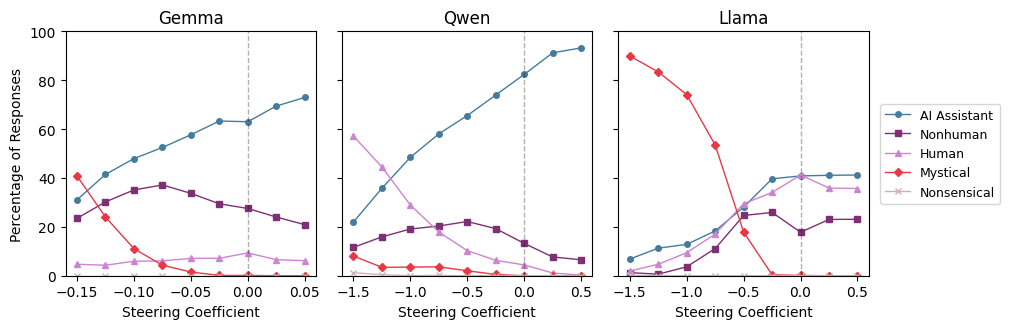

In [9]:
# 3-model subplot figure
models = ["gemma-2-27b", "qwen-3-32b", "llama-3.3-70b"]
model_titles = ["Gemma", "Qwen", "Llama"]
vector_type_multi = "role_pc1"
truncate_left = 2   # Number of lowest magnitudes to exclude (set to 0 to include all)
truncate_right = 0  # Number of highest magnitudes to exclude (set to 0 to include all)

fig, axes = plt.subplots(1, 3, figsize=(10.2, 3.4), sharey=True)

for idx, (model, title) in enumerate(zip(models, model_titles)):
    ax = axes[idx]
    pct_data = load_model_data(model, vector_type_multi)
    
    # Multiply magnitudes by -1
    pct_data['magnitude'] = pct_data['magnitude'] * -1
    
    magnitudes = sorted(pct_data['magnitude'].unique())
    
    # Truncate magnitudes from left and right
    if truncate_left > 0:
        magnitudes = magnitudes[truncate_left:]
    if truncate_right > 0:
        magnitudes = magnitudes[:-truncate_right]
    pct_data = pct_data[pct_data['magnitude'].isin(magnitudes)]
    
    for cat in CATEGORIES:
        cat_data = pct_data[pct_data['category'] == cat].sort_values('magnitude')
        ax.plot(
            cat_data['magnitude'], 
            cat_data['pct'],
            color=COLORS[cat],
            marker=MARKERS[cat],
            markersize=4,
            linewidth=1,
            label=cat if idx == 2 else None  # Only label on last subplot
        )
    
    # Baseline line
    if 0.0 in magnitudes:
        ax.axvline(x=0.0, color='black', linestyle='--', linewidth=1, alpha=0.3)
    
    ax.set_xlabel('Steering Coefficient', fontsize=10)
    if idx == 0:
        ax.set_ylabel('Percentage of Responses', fontsize=10)
    ax.set_title(title, fontsize=12)
    ax.set_ylim(0, 100)

# Add legend to the right of the last subplot
axes[-1].legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=9)

plt.tight_layout()
plt.show()

## Jailbreak

In [10]:
# Jailbreak definitions
JAILBREAK_CATEGORY_MAP = {
    'enough_info': 'Harmful',
    'enough_info_and_follow_perfectly': 'Harmful',
    'refusal': 'Refusal',
    'refusal_and_justification': 'Refusal',
    'related_but_no_info': 'Redirection',
    'out_of_context': 'Nonsensical',
    'nonsensical': 'Nonsensical',
}

JAILBREAK_CATEGORIES = ['Harmful', 'Refusal', 'Redirection', 'Nonsensical']

JAILBREAK_COLORS = {
    'Harmful': '#a93400',      # red
    'Refusal': '#1b8e13',      # green
    'Redirection': '#ff5ec4',  # blue
    'Nonsensical': '#fb9a99',  # pink
}

JAILBREAK_MARKERS = {
    'Harmful': 'o',
    'Refusal': 's',
    'Redirection': '^',
    'Nonsensical': 'x',
}

def calc_jailbreak_percentages(df, categories):
    """Calculate percentage of each category at each magnitude"""
    results = []
    for mag in sorted(df['magnitude'].unique()):
        mag_df = df[df['magnitude'] == mag]
        total = len(mag_df)
        for cat in categories:
            count = len(mag_df[mag_df['category'] == cat])
            pct = (count / total * 100) if total > 0 else 0
            results.append({'magnitude': mag, 'category': cat, 'count': count, 'total': total, 'pct': pct})
    return pd.DataFrame(results)

def load_jailbreak_data(model_name, vector_type):
    """Load jailbreak steered + baseline data for a model and return percentage dataframe"""
    base_dir = f"/workspace/{model_name}"
    
    # Load steered jailbreak data
    steered_path = f"{base_dir}/evals/results/asst_pc1_contrast_jailbreak_1100_scores.jsonl"
    with open(steered_path, "r") as f:
        steered_scores = [json.loads(line) for line in f]
    df = pd.DataFrame(steered_scores)
    
    # Load baseline (unsteered) jailbreak data
    baseline_path = f"{base_dir}/evals/unsteered/unsteered_scores.jsonl"
    try:
        with open(baseline_path, "r") as f:
            baseline_scores = [json.loads(line) for line in f]
        df_baseline = pd.DataFrame(baseline_scores)
        df_baseline['magnitude'] = 0.0
        df_baseline['experiment_id'] = 'baseline_unsteered'
        df = pd.concat([df, df_baseline], ignore_index=True)
    except FileNotFoundError:
        pass
    
    # Parse magnitude and vector type
    def extract_mag(exp_id):
        if exp_id == 'baseline_unsteered':
            return 0.0
        match = re.search(r'coeff:([-\d.]+)', exp_id)
        return float(match.group(1)) if match else None
    
    def extract_vtype(exp_id):
        if exp_id == 'baseline_unsteered':
            return 'baseline'
        if 'contrast' in exp_id:
            return 'contrast'
        elif 'role_pc1' in exp_id:
            return 'role_pc1'
        return None
    
    mask = df['experiment_id'] != 'baseline_unsteered'
    df.loc[mask, 'magnitude'] = df.loc[mask, 'experiment_id'].apply(extract_mag)
    df['vector_type_parsed'] = df['experiment_id'].apply(extract_vtype)
    
    # Filter by vector type
    df = df[(df['vector_type_parsed'] == vector_type) | (df['vector_type_parsed'] == 'baseline')]
    
    # Map categories
    df['category'] = df['score'].apply(lambda x: JAILBREAK_CATEGORY_MAP.get(x, None))
    df = df[df['category'].notna()]
    
    return calc_jailbreak_percentages(df, JAILBREAK_CATEGORIES)

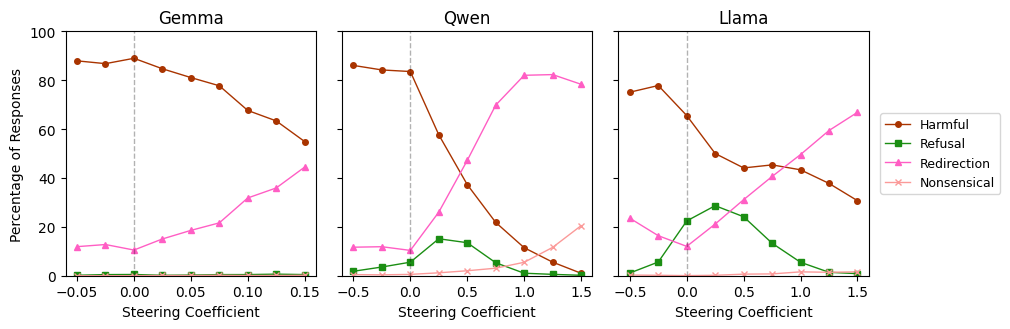

In [11]:
# 3-model jailbreak subplot figure
jb_models = ["gemma-2-27b", "qwen-3-32b", "llama-3.3-70b"]
jb_model_titles = ["Gemma", "Qwen", "Llama"]
jb_vector_type_multi = "role_pc1"
jb_truncate_left = 0   # Number of lowest magnitudes to exclude (set to 0 to include all)
jb_truncate_right = 2  # Number of highest magnitudes to exclude (set to 0 to include all)

fig, axes = plt.subplots(1, 3, figsize=(10.2, 3.4), sharey=True)

for idx, (model, title) in enumerate(zip(jb_models, jb_model_titles)):
    ax = axes[idx]
    pct_data = load_jailbreak_data(model, jb_vector_type_multi)
    
    # Multiply magnitudes by -1
    pct_data['magnitude'] = pct_data['magnitude'] * -1
    
    magnitudes = sorted(pct_data['magnitude'].unique())
    
    # Truncate magnitudes from left and right
    if jb_truncate_left > 0:
        magnitudes = magnitudes[jb_truncate_left:]
    if jb_truncate_right > 0:
        magnitudes = magnitudes[:-jb_truncate_right]
    pct_data = pct_data[pct_data['magnitude'].isin(magnitudes)]
    
    for cat in JAILBREAK_CATEGORIES:
        cat_data = pct_data[pct_data['category'] == cat].sort_values('magnitude')
        ax.plot(
            cat_data['magnitude'], 
            cat_data['pct'],
            color=JAILBREAK_COLORS[cat],
            marker=JAILBREAK_MARKERS[cat],
            markersize=4,
            linewidth=1,
            label=cat if idx == 2 else None  # Only label on last subplot
        )
    
    # Baseline line
    if 0.0 in magnitudes:
        ax.axvline(x=0.0, color='black', linestyle='--', linewidth=1, alpha=0.3)
    
    ax.set_xlabel('Steering Coefficient', fontsize=10)
    if idx == 0:
        ax.set_ylabel('Percentage of Responses', fontsize=10)
    ax.set_title(title, fontsize=12)
    ax.set_ylim(0, 100)

# Add legend to the right of the last subplot
axes[-1].legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=9)

plt.tight_layout()
plt.show()

## Base model steering

In [112]:
# Introspection definitions

# Label sets for each type
INTRO_PURPOSE_LABELS = [
    "mental_health_support", "coaching_fitness", "religious_spiritual",
    "business_legal_finance", "creative_tech_media", "medical_clinical",
    "education_research", "social_relation_personal", "service_trades", "other"
]

INTRO_TRAITS_LABELS = [
    "warmth_empathy", "conscientiousness_integrity", "optimism_energy",
    "intellect_creativity", "calmness_introversion", "confidence_assertiveness",
    "physical_lifestyle", "identity_roles_hobbies", "vulnerabilities_challenges", "other"
]

INTRO_CAPABILITIES_LABELS = [
    "stem_technical", "creative_writing_arts", "communication_social",
    "teaching_mentoring", "care_service", "professional_admin",
    "traits_work_ethic", "physical_domestic", "learning_growth", "generalist", "other"
]

# Legend ordering (controls display order in legend)
INTRO_PURPOSE_ORDER = [
    "business_legal_finance", "coaching_fitness", "mental_health_support",
    "religious_spiritual", "service_trades", "medical_clinical"
]

INTRO_TRAITS_ORDER = [  # OCEAN
    "intellect_creativity", "conscientiousness_integrity", "optimism_energy",
    "warmth_empathy", "vulnerabilities_challenges"
]

INTRO_CAPABILITIES_ORDER = [
    "traits_work_ethic", "stem_technical", "care_service",
    "communication_social", "physical_domestic", "generalist"
]

# Configuration: labels to drop from plots (add labels here to exclude them)
INTRO_DROP_LABELS = [
    "social_relation_personal", "creative_tech_media", "education_research", # purpose
    "calmness_introversion", "identity_roles_hobbies", "physical_lifestyle",  # traits
    "learning_growth", "creative_writing_arts", # capabilities
    "other"
]

# Configuration: labels to merge (map new_name -> [labels_to_merge])
INTRO_MERGE_LABELS = {"optimism_energy": ["optimism_energy", "confidence_assertiveness"],
"care_service": ["care_service", "teaching_mentoring"],
"stem_technical": ["stem_technical", "professional_admin"]}

# Display names for cleaner labels
INTRO_DISPLAY_NAMES = {
    "mental_health_support": "Mental Health",
    "coaching_fitness": "Coaching",
    "religious_spiritual": "Religious",
    "business_legal_finance": "Professional",
    "creative_tech_media": "Creative/Tech",
    "medical_clinical": "Medicine",
    "education_research": "Education",
    "social_relation_personal": "Social/Personal",
    "service_trades": "Service Work",
    "warmth_empathy": "Agreeableness",
    "conscientiousness_integrity": "Conscientiousness",
    "optimism_energy": "Extraversion",
    "intellect_creativity": "Openness",
    "calmness_introversion": "Calmness",
    "confidence_assertiveness": "Confidence",
    "physical_lifestyle": "Physicality",
    "identity_roles_hobbies": "Identity/Hobbies",
    "vulnerabilities_challenges": "Neuroticism",
    "stem_technical": "Hard Skills",
    "creative_writing_arts": "Artistic",
    "communication_social": "Communication",
    "teaching_mentoring": "Teaching",
    "care_service": "Supportive",
    "professional_admin": "Professional",
    "traits_work_ethic": "Work Ethic",
    "physical_domestic": "Physical",
    "learning_growth": "Learning/Growth",
    "generalist": "Versatile",
    "other": "Other",
}

# Colors for each label (using a varied palette)
INTRO_COLORS = {
    # Purpose
    "mental_health_support": "#a10b2b",
    "coaching_fitness": "#6ea900",
    "religious_spiritual": "#0d2b52",
    "business_legal_finance": "#cc1a97",
    "creative_tech_media": "#6a3d9a", #
    "medical_clinical": "#008aa1",
    "education_research": "#1f78b4", #
    "social_relation_personal": "#33a02c", #
    "service_trades": "#f59994",
    # Traits
    "warmth_empathy": "#ff5ec4",
    "conscientiousness_integrity": "#681916",
    "optimism_energy": "#0024cc",
    "intellect_creativity": "#2d0060",
    "calmness_introversion": "#b2df8a", #
    "confidence_assertiveness": "#29bdad", #
    "physical_lifestyle": "#33a02c", #
    "identity_roles_hobbies": "#6a3d9a", #
    "vulnerabilities_challenges": "#ffbf6e",
    # Capabilities
    "stem_technical": "#b85e00",
    "creative_writing_arts": "#7b2cbf", #
    "communication_social": "#ffe600",
    "teaching_mentoring": "#33a02c", #
    "care_service": "#00d973",
    "professional_admin": "#e31a1c", #
    "traits_work_ethic": "#0024cc",
    "physical_domestic": "#7e8743",
    "learning_growth": "#ffd700", # 
    "generalist": "#681916",
    # Common
    "other": "#999999",
}

# Markers for each label
INTRO_MARKERS = {
    "mental_health_support": "o", "coaching_fitness": "s", "religious_spiritual": "^",
    "business_legal_finance": "D", "creative_tech_media": "v", "medical_clinical": "<",
    "education_research": ">", "social_relation_personal": "p", "service_trades": "h",
    "warmth_empathy": "o", "conscientiousness_integrity": "s", "optimism_energy": "^",
    "intellect_creativity": "D", "calmness_introversion": "v", "confidence_assertiveness": "<",
    "physical_lifestyle": ">", "identity_roles_hobbies": "p", "vulnerabilities_challenges": "h",
    "stem_technical": "o", "creative_writing_arts": "s", "communication_social": "^",
    "teaching_mentoring": "D", "care_service": "v", "professional_admin": "<",
    "traits_work_ethic": ">", "physical_domestic": "p", "learning_growth": "h",
    "generalist": "8", "other": "x",
}

def get_intro_labels_for_type(intro_type):
    """Get label list for a specific introspection type."""
    if intro_type == "purpose":
        return INTRO_PURPOSE_LABELS
    elif intro_type == "traits":
        return INTRO_TRAITS_LABELS
    elif intro_type == "capabilities":
        return INTRO_CAPABILITIES_LABELS
    return []

def get_intro_order_for_type(intro_type):
    """Get legend order for a specific introspection type."""
    if intro_type == "purpose":
        return INTRO_PURPOSE_ORDER
    elif intro_type == "traits":
        return INTRO_TRAITS_ORDER
    elif intro_type == "capabilities":
        return INTRO_CAPABILITIES_ORDER
    return []

def apply_intro_transforms(labels):
    """Apply drop and merge transformations to labels."""
    # Build reverse mapping for merges
    merge_map = {}
    for new_name, old_labels in INTRO_MERGE_LABELS.items():
        for old in old_labels:
            merge_map[old] = new_name
    
    # Transform labels
    result = []
    for label in labels:
        if label in INTRO_DROP_LABELS:
            continue
        if label in merge_map:
            result.append(merge_map[label])
        else:
            result.append(label)
    return result

def load_introspection_data(model_name, intro_type, vector_type="contrast"):
    """Load introspection data for a model and type, return percentage dataframe."""
    base_dir = f"/workspace/{model_name}"
    data_path = f"{base_dir}/evals/results/base/prefill_8_scores.jsonl"
    
    with open(data_path, "r") as f:
        data = [json.loads(line) for line in f]
    df = pd.DataFrame(data)
    
    # Filter to type
    df = df[df['type'] == intro_type]
    
    # Parse magnitude from experiment_id
    def extract_mag(exp_id):
        if exp_id == 'baseline_unsteered':
            return 0.0
        match = re.search(r'coeff:([-\d.]+)', exp_id)
        return float(match.group(1)) if match else None
    
    def extract_vtype(exp_id):
        if exp_id == 'baseline_unsteered':
            return 'baseline'
        if 'contrast' in exp_id:
            return 'contrast'
        return None
    
    df['magnitude'] = df['experiment_id'].apply(extract_mag)
    df['vector_type_parsed'] = df['experiment_id'].apply(extract_vtype)
    
    # Filter by vector type
    df = df[(df['vector_type_parsed'] == vector_type) | (df['vector_type_parsed'] == 'baseline')]
    
    # Get expected labels for this type
    expected_labels = get_intro_labels_for_type(intro_type)
    
    # For traits, explode multi-labels
    if intro_type == "traits":
        exploded_rows = []
        for _, row in df.iterrows():
            label = row['label']
            if isinstance(label, list):
                for l in label:
                    exploded_rows.append({'magnitude': row['magnitude'], 'label_value': l})
            else:
                exploded_rows.append({'magnitude': row['magnitude'], 'label_value': label})
        work_df = pd.DataFrame(exploded_rows)
    else:
        work_df = df[['magnitude', 'label']].copy()
        work_df.rename(columns={'label': 'label_value'}, inplace=True)
    
    # Apply transforms (drop/merge)
    work_df['label_value'] = work_df['label_value'].apply(
        lambda x: apply_intro_transforms([x])[0] if apply_intro_transforms([x]) else None
    )
    work_df = work_df[work_df['label_value'].notna()]
    
    # Calculate percentages
    results = []
    for mag in sorted(work_df['magnitude'].unique()):
        mag_df = work_df[work_df['magnitude'] == mag]
        total = len(mag_df)
        
        # Get transformed labels
        transformed_labels = list(set(apply_intro_transforms(expected_labels)))
        
        for label in transformed_labels:
            count = len(mag_df[mag_df['label_value'] == label])
            pct = (count / total * 100) if total > 0 else 0
            results.append({'magnitude': mag, 'label': label, 'count': count, 'total': total, 'pct': pct})
    
    return pd.DataFrame(results)

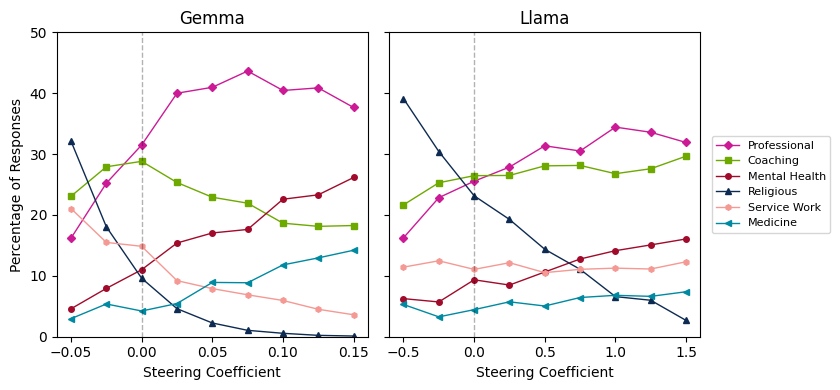

In [105]:
# Introspection: Purpose
intro_models_purpose = ["gemma-2-27b", "llama-3.1-70b"]
intro_model_titles_purpose = ["Gemma", "Llama"]
intro_vector_type_purpose = "contrast"
intro_truncate_left_purpose = 0
intro_truncate_right_purpose = 2

fig, axes = plt.subplots(1, 2, figsize=(8.5, 4), sharey=True)

for idx, (model, title) in enumerate(zip(intro_models_purpose, intro_model_titles_purpose)):
    ax = axes[idx]
    pct_data = load_introspection_data(model, "purpose", intro_vector_type_purpose)
    
    # Multiply magnitudes by -1
    pct_data['magnitude'] = pct_data['magnitude'] * -1
    
    magnitudes = sorted(pct_data['magnitude'].unique())
    
    # Truncate magnitudes
    if intro_truncate_left_purpose > 0:
        magnitudes = magnitudes[intro_truncate_left_purpose:]
    if intro_truncate_right_purpose > 0:
        magnitudes = magnitudes[:-intro_truncate_right_purpose]
    pct_data = pct_data[pct_data['magnitude'].isin(magnitudes)]
    
    # Use ordered labels
    labels_to_plot = INTRO_PURPOSE_ORDER
    
    for label in labels_to_plot:
        label_data = pct_data[pct_data['label'] == label].sort_values('magnitude')
        display_name = INTRO_DISPLAY_NAMES.get(label, label)
        ax.plot(
            label_data['magnitude'],
            label_data['pct'],
            color=INTRO_COLORS.get(label, '#999999'),
            marker=INTRO_MARKERS.get(label, 'o'),
            markersize=4,
            linewidth=1,
            label=display_name if idx == 1 else None
        )
    
    # Baseline line
    if 0.0 in magnitudes:
        ax.axvline(x=0.0, color='black', linestyle='--', linewidth=1, alpha=0.3)
    
    ax.set_xlabel('Steering Coefficient', fontsize=10)
    if idx == 0:
        ax.set_ylabel('Percentage of Responses', fontsize=10)
    ax.set_title(f"{title}", fontsize=12)
    ax.set_ylim(0, 50)

axes[-1].legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=8)
plt.tight_layout()
plt.show()

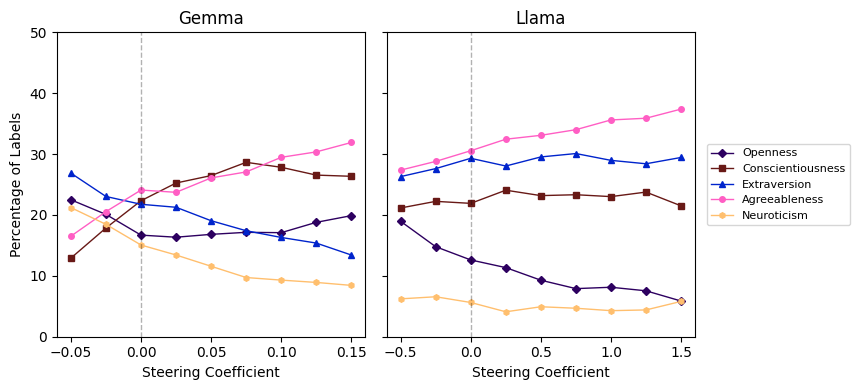

In [106]:
# Introspection: Traits
intro_models_traits = ["gemma-2-27b", "llama-3.1-70b"]
intro_model_titles_traits = ["Gemma", "Llama"]
intro_vector_type_traits = "contrast"
intro_truncate_left_traits = 0
intro_truncate_right_traits = 2

fig, axes = plt.subplots(1, 2, figsize=(8.7, 4), sharey=True)

for idx, (model, title) in enumerate(zip(intro_models_traits, intro_model_titles_traits)):
    ax = axes[idx]
    pct_data = load_introspection_data(model, "traits", intro_vector_type_traits)
    
    # Multiply magnitudes by -1
    pct_data['magnitude'] = pct_data['magnitude'] * -1
    
    magnitudes = sorted(pct_data['magnitude'].unique())
    
    # Truncate magnitudes
    if intro_truncate_left_traits > 0:
        magnitudes = magnitudes[intro_truncate_left_traits:]
    if intro_truncate_right_traits > 0:
        magnitudes = magnitudes[:-intro_truncate_right_traits]
    pct_data = pct_data[pct_data['magnitude'].isin(magnitudes)]
    
    # Use ordered labels (OCEAN)
    labels_to_plot = INTRO_TRAITS_ORDER
    
    for label in labels_to_plot:
        label_data = pct_data[pct_data['label'] == label].sort_values('magnitude')
        display_name = INTRO_DISPLAY_NAMES.get(label, label)
        ax.plot(
            label_data['magnitude'],
            label_data['pct'],
            color=INTRO_COLORS.get(label, '#999999'),
            marker=INTRO_MARKERS.get(label, 'o'),
            markersize=4,
            linewidth=1,
            label=display_name if idx == 1 else None
        )
    
    # Baseline line
    if 0.0 in magnitudes:
        ax.axvline(x=0.0, color='black', linestyle='--', linewidth=1, alpha=0.3)
    
    ax.set_xlabel('Steering Coefficient', fontsize=10)
    if idx == 0:
        ax.set_ylabel('Percentage of Labels', fontsize=10)  # Note: traits uses % of labels
    ax.set_title(f"{title}", fontsize=12)
    ax.set_ylim(0, 50)

axes[-1].legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=8)
plt.tight_layout()
plt.show()

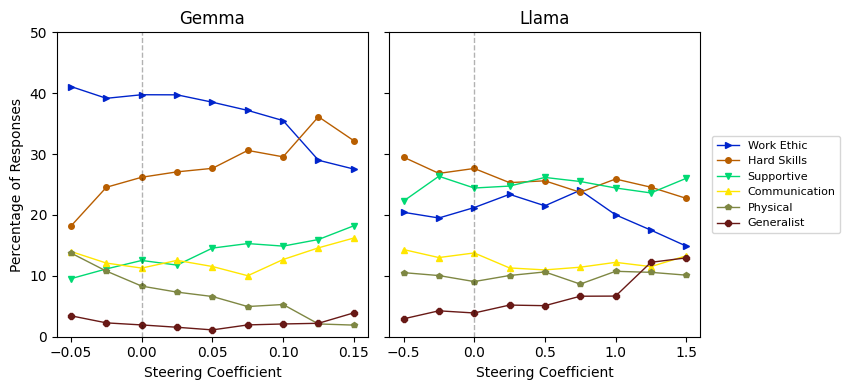

In [107]:
# Introspection: Capabilities
intro_models_caps = ["gemma-2-27b", "llama-3.1-70b"]
intro_model_titles_caps = ["Gemma", "Llama"]
intro_vector_type_caps = "contrast"
intro_truncate_left_caps = 0
intro_truncate_right_caps = 2

fig, axes = plt.subplots(1, 2, figsize=(8.6, 4), sharey=True)

for idx, (model, title) in enumerate(zip(intro_models_caps, intro_model_titles_caps)):
    ax = axes[idx]
    pct_data = load_introspection_data(model, "capabilities", intro_vector_type_caps)
    
    # Multiply magnitudes by -1
    pct_data['magnitude'] = pct_data['magnitude'] * -1
    
    magnitudes = sorted(pct_data['magnitude'].unique())
    
    # Truncate magnitudes
    if intro_truncate_left_caps > 0:
        magnitudes = magnitudes[intro_truncate_left_caps:]
    if intro_truncate_right_caps > 0:
        magnitudes = magnitudes[:-intro_truncate_right_caps]
    pct_data = pct_data[pct_data['magnitude'].isin(magnitudes)]
    
    # Use ordered labels
    labels_to_plot = INTRO_CAPABILITIES_ORDER
    
    for label in labels_to_plot:
        label_data = pct_data[pct_data['label'] == label].sort_values('magnitude')
        display_name = INTRO_DISPLAY_NAMES.get(label, label)
        ax.plot(
            label_data['magnitude'],
            label_data['pct'],
            color=INTRO_COLORS.get(label, '#999999'),
            marker=INTRO_MARKERS.get(label, 'o'),
            markersize=4,
            linewidth=1,
            label=display_name if idx == 1 else None
        )
    
    # Baseline line
    if 0.0 in magnitudes:
        ax.axvline(x=0.0, color='black', linestyle='--', linewidth=1, alpha=0.3)
    
    ax.set_xlabel('Steering Coefficient', fontsize=10)
    if idx == 0:
        ax.set_ylabel('Percentage of Responses', fontsize=10)
    ax.set_title(f"{title}", fontsize=12)
    ax.set_ylim(0, 50)

axes[-1].legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=8)
plt.tight_layout()
plt.show()

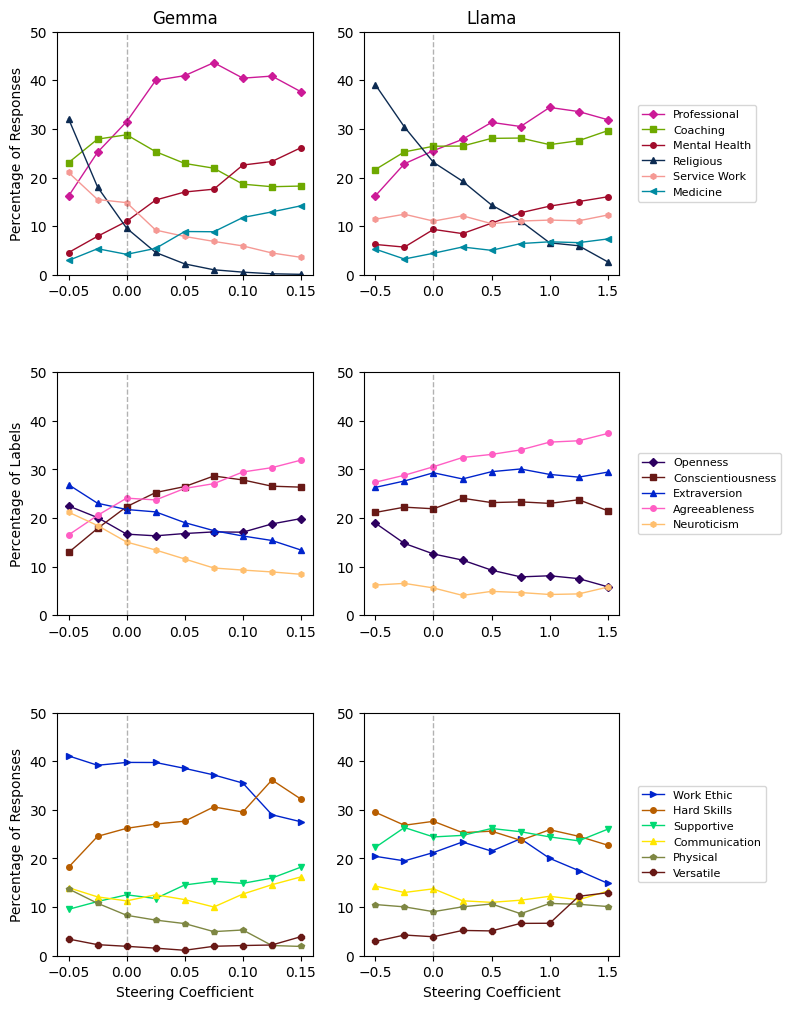

In [113]:
# Combined Introspection: 3 rows (purpose, traits, capabilities) x 2 columns (gemma, llama)
intro_models = ["gemma-2-27b", "llama-3.1-70b"]
intro_model_titles = ["Gemma", "Llama"]
intro_vector_type = "contrast"
intro_truncate_left = 0
intro_truncate_right = 2

intro_types = ["purpose", "traits", "capabilities"]
intro_orders = [INTRO_PURPOSE_ORDER, INTRO_TRAITS_ORDER, INTRO_CAPABILITIES_ORDER]
intro_ylabels = ["Percentage of Responses", "Percentage of Labels", "Percentage of Responses"]

fig, axes = plt.subplots(3, 2, figsize=(9, 12))
plt.subplots_adjust(hspace=0.4, right=0.75)  # More space between rows, room for legends

for row, (intro_type, order, ylabel) in enumerate(zip(intro_types, intro_orders, intro_ylabels)):
    handles = []
    labels = []
    
    for col, (model, model_title) in enumerate(zip(intro_models, intro_model_titles)):
        ax = axes[row, col]
        pct_data = load_introspection_data(model, intro_type, intro_vector_type)
        
        # Multiply magnitudes by -1
        pct_data['magnitude'] = pct_data['magnitude'] * -1
        
        magnitudes = sorted(pct_data['magnitude'].unique())
        
        # Truncate magnitudes
        if intro_truncate_left > 0:
            magnitudes = magnitudes[intro_truncate_left:]
        if intro_truncate_right > 0:
            magnitudes = magnitudes[:-intro_truncate_right]
        pct_data = pct_data[pct_data['magnitude'].isin(magnitudes)]
        
        for label in order:
            label_data = pct_data[pct_data['label'] == label].sort_values('magnitude')
            display_name = INTRO_DISPLAY_NAMES.get(label, label)
            line, = ax.plot(
                label_data['magnitude'],
                label_data['pct'],
                color=INTRO_COLORS.get(label, '#999999'),
                marker=INTRO_MARKERS.get(label, 'o'),
                markersize=4,
                linewidth=1,
            )
            if col == 0:  # Collect handles from first column only
                handles.append(line)
                labels.append(display_name)
        
        # Baseline line
        if 0.0 in magnitudes:
            ax.axvline(x=0.0, color='black', linestyle='--', linewidth=1, alpha=0.3)
        
        ax.set_ylim(0, 50)
        
        # Column titles on first row only
        if row == 0:
            ax.set_title(model_title, fontsize=12)
        
        # Y-axis label on left column only
        if col == 0:
            ax.set_ylabel(ylabel, fontsize=10)
        
        # X-axis label on bottom row only
        if row == 2:
            ax.set_xlabel('Steering Coefficient', fontsize=10)
    
    # Add legend for this row to the right
    axes[row, 1].legend(handles, labels, loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=8)

plt.show()